In [1]:
!pip install shap opencv-python

# Imports & Global Setup

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import (
    ResNet50, preprocess_input, decode_predictions
)
import shap
from matplotlib import patheffects # For text outline in grid visualization
import cv2
from google.colab import files
from PIL import Image
import io

# Model & Data Loading




We use the ResNet50 model, which was previously trained on ImageNet. We can try one of the 50 SHAP examples using the index number.


In [17]:
# Load pre-trained ResNet50 model
model = ResNet50(weights="imagenet")

# Load an ImageNet sample image from SHAP's dataset
X, y = shap.datasets.imagenet50()
image_index = 1
img = X[image_index]
true_label = y[image_index]

# Preprocess the image for ResNet50
img_resized = np.expand_dims(img, axis=0)
img_resized = preprocess_input(img_resized)

# Display Original Image & Predictions


Shows the raw image (rescaled for visibility) and overlays the top-3 predicted class names & confidences.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


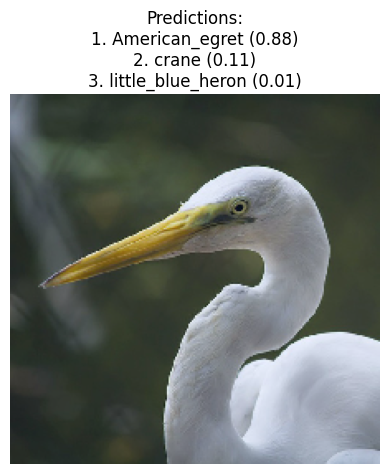

In [18]:
# Get model predictions
preds = model.predict(img_resized)
decoded_preds = decode_predictions(preds, top=3)[0]

# Display the image with predicted class labels
plt.imshow((img - img.min()) / (img.max() - img.min()))  # Normalize to 0-1
plt.axis('off')
plt.title(f"Predictions:\n1. {decoded_preds[0][1]} ({decoded_preds[0][2]:.2f})\n"
          f"2. {decoded_preds[1][1]} ({decoded_preds[1][2]:.2f})\n"
          f"3. {decoded_preds[2][1]} ({decoded_preds[2][2]:.2f})")
plt.show()

# GridExplainer Class Definition

Segments the image into an 8×8 grid. Perturbs each cell (replace with mean) and measures confidence drop. Aggregates importance scores per cell. Visualizes those scores over a semi-transparent background

In [19]:
class GridExplainer:
    def __init__(self, model, grid_size=8):
        self.model = model
        self.grid_size = grid_size

    def _create_grid_mask(self, img_shape):
        """Generate grid segmentation mask"""
        h, w = img_shape[:2]
        self.segments = np.zeros((h, w), dtype=int)
        cell_h = h // self.grid_size
        cell_w = w // self.grid_size

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                x_start = i * cell_h
                x_end = (i + 1) * cell_h if i != self.grid_size - 1 else h
                y_start = j * cell_w
                y_end = (j + 1) * cell_w if j != self.grid_size - 1 else w
                self.segments[x_start:x_end, y_start:y_end] = i * self.grid_size + j
        return self.segments

    def _perturb_image(self, img, segment_id):
        """Perturb image by masking out the target grid cell"""
        mask = self.segments == segment_id
        perturbed = img.copy()
        # Replace only the target grid cell with its mean value, leaving the rest intact
        perturbed[mask] = perturbed[mask].mean()
        return preprocess_input(perturbed)

    def explain(self, img, target_class=None):
        """Calculate grid importance scores"""
        # Normalize original image for visualization
        self.original_img = (img - img.min()) / (img.max() - img.min())
        self.img_shape = img.shape
        self._create_grid_mask(img.shape)

        # Get original prediction
        original_img_preprocessed = preprocess_input(img.copy())
        original_pred = self.model.predict(np.expand_dims(original_img_preprocessed, 0))
        if target_class is None:
            target_class = np.argmax(original_pred)

        # Calculate importance for each grid cell
        self.importance_scores = []
        for seg_id in range(self.grid_size**2):
            perturbed = self._perturb_image(img, seg_id)
            pred = self.model.predict(np.expand_dims(perturbed, 0))
            # The importance is the drop in confidence when the grid cell is masked
            self.importance_scores.append(original_pred[0][target_class] - pred[0][target_class])

        return self.importance_scores

    def visualize(self, background_alpha=0.3):
        """Visualize grid importance with a semi-transparent image background"""
        h, w = self.img_shape[:2]
        cell_h = h // self.grid_size
        cell_w = w // self.grid_size

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        # Display the normalized original image with transparency
        ax.imshow(self.original_img, alpha=background_alpha)
        ax.set_axis_off()

        # Normalize scores to a 0-100 scale for visualization
        abs_scores = np.abs(self.importance_scores)
        max_score = abs_scores.max() if abs_scores.max() != 0 else 1
        norm_scores = (abs_scores / max_score) * 100

        # Draw grid lines
        for i in range(self.grid_size + 1):
            ax.axhline(i * cell_h, color='white', linewidth=2, alpha=0.9)
            ax.axvline(i * cell_w, color='white', linewidth=2, alpha=0.9)

        # Add importance values on each grid cell
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                idx = i * self.grid_size + j
                value = norm_scores[idx]
                x_center = j * cell_w + cell_w // 2
                y_center = i * cell_h + cell_h // 2

                ax.text(x_center, y_center, f"{int(value)}",
                        color='white', ha='center', va='center',
                        fontsize=12, weight='bold',
                        path_effects=[
                            patheffects.withStroke(linewidth=2, foreground='black'),
                            patheffects.Normal()
                        ])

        plt.xlim(0, w)
        plt.ylim(h, 0)
        plt.title("Grid Importance (0-100 scale)", color='black', pad=20)
        plt.tight_layout()
        plt.show()

# Run explainer


Generating Grid Explanation...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208m

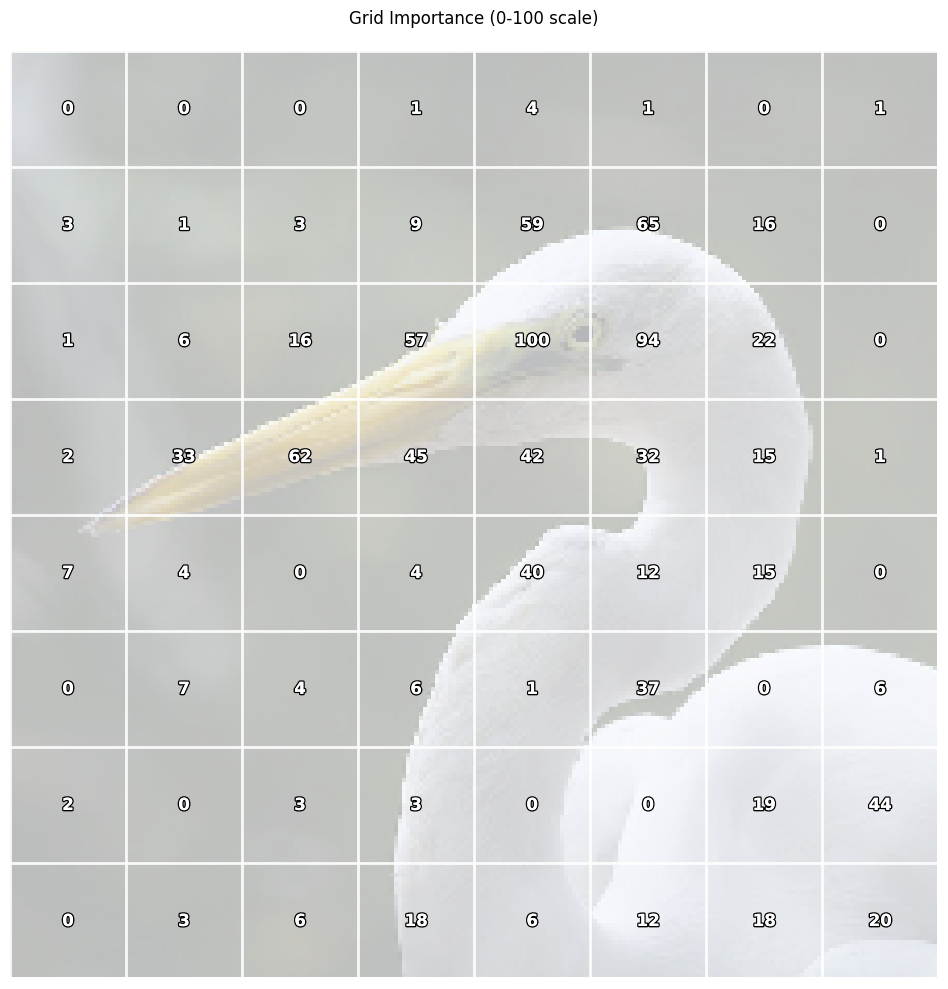

In [20]:
print("\nGenerating Grid Explanation...")
explainer = GridExplainer(model, grid_size=8)
explainer.explain(img)
explainer.visualize(background_alpha=0.3)